HW5_Q4_Time Series Classification Part 2: Binary and Multiclass Classification - Hardik Prajapati(2678294168)

In [107]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.utils import resample
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

In [5]:
warnings.filterwarnings('ignore')

data_file = "../data/AReM"

dirToRead = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
columns_main = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

Q7_b: test train split

In [6]:
def traintest_split(root):
    training_files = []
    testing_files = []
    for root, _, file in os.walk(root):
        for f in file:
            if (os.path.splitext(f)[1] == ".csv"):
                idx_csv = int(re.findall("\d+", f)[0])
                file_name = os.path.join(root, f)
                file_split = os.path.split(root)[-1]
                if (idx_csv <= 2 or (file_split not in ["bending1", "bending2"] and idx_csv == 3)):
                    testing_files.append(file_name)
                else:
                    training_files.append(file_name)
    return training_files, testing_files

train_data, test_data = traintest_split(data_file)


Q1_c: Feature Extraction

In [7]:
def read_data(files, feature, col, segs=1, standard=False):
    import csv
    sniffer = csv.Sniffer()
    
    feature_order = ['mean', 'std', 'min', '1stqtl', 'median', '3rdqtl','max']
    feature_idx = [feature + str(i) for i in range(1, 6 * segs + 1) for feature in feature_order]
    
    sample  = []
    labels = []
    for fil in files:
        parent_folder = os.path.dirname(fil)
        file_split = os.path.split(parent_folder)[-1]
        labels.append(file_split)
        
        separator = sniffer.sniff(open(fil).read()).delimiter
        if separator == ",":
            instance = pd.read_csv(fil, skiprows=5, header=None, 
                                       error_bad_lines=False, warn_bad_lines=False)
        else:
            instance = pd.read_csv(fil, skiprows=5, header=None, sep="\s+", 
                                       error_bad_lines=False, warn_bad_lines=False)
        
        instance.columns = col
        seg_len = int(instance.shape[0] / segs)
        segs_describe = []
        for i in range(segs):
            seg = instance[i * seg_len : min((i + 1) * seg_len, instance.shape[0])]
            describe = seg.describe().drop('count').drop(columns="# Columns: time").T
            segs_describe.append(describe.values.flatten())
        sample.append(np.concatenate(segs_describe, axis=None))
    
    feature_df = pd.DataFrame(sample, columns=feature_idx)
    feature_df = feature_df.loc[:, feature]
    
    if standard:
        feature_df = feature_df.apply(lambda col: (col-col.mean()) / (np.std(col) + 1e-9), axis = 0)
    

    feature_df['label'] = pd.Series(labels)
    
    return feature_df

statistics = ['min','max','mean','median','std','1stqtl', '3rdqtl']
feature = [stat + str(i) for i in range(1, 7) for stat in statistics]


train_df = read_data(train_data, feature, columns_main)
test_df = read_data(test_data, feature, columns_main)

In [8]:
train_df

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1
1,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.490,0.487826,0.00,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking
65,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking


In [9]:
test_df

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372437,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
5,28.75,44.75,37.561187,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080687,...,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,cycling
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,cycling
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363687,...,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,lying
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,lying
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,lying


Q7_c_ii: Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

Time-domain features used in time-series classification.
Statistical Features:
1. Mean: It is the best measure of central tendency when the data distribution is continuous.
2. Median: It is a good feature of central tendency that is less affected by outliers and skewed data.
3. Standard Deviation: It is an ideal measure of dispersion.
4. Skewness
5. Minimum and Maximum : They are the extreme values of the range

Q7_c_iii: Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python's bootstrapped or any other
method to build a 90% bootsrap confidence interval for the standard deviation
of each feature

In [10]:
train_df.describe().loc['std']

min1       8.794295
max1       4.429182
mean1      4.917692
median1    4.956111
std1       1.758670
1stqtl1    5.731647
3rdqtl1    4.783645
min2       0.000000
max2       5.147841
mean2      1.600701
median2    1.436960
std2       0.902808
1stqtl2    0.952201
3rdqtl2    2.158416
min3       3.053869
max3       4.759853
mean3      3.863097
median3    3.845730
std3       0.995959
1stqtl3    4.145255
3rdqtl3    3.946023
min4       0.000000
max4       2.302408
mean4      1.179861
median4    1.150092
std4       0.473576
1stqtl4    0.842501
3rdqtl4    1.566564
min5       5.368786
max5       5.449726
mean5      5.120426
median5    5.267414
std5       1.057998
1stqtl5    5.543882
3rdqtl5    4.957231
min6       0.051766
max6       2.540166
mean6      1.171401
median6    1.104626
std6       0.519420
1stqtl6    0.774358
3rdqtl6    1.550393
Name: std, dtype: float64

In [11]:
def boot_strap(data, num_resample, operation, low=5, upper=95):
    estimation = []
    for i in range(num_resample):
        resampled_data = resample(data, replace=True, n_samples=data.shape[0])
        estimation.append(resampled_data.apply(lambda col : operation(col, ddof=1), axis=0))
    estimation = pd.DataFrame(estimation, columns=list(data.columns))
    conf_interval = estimation.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
    return conf_interval.apply(np.around, args=(2,))

our_interval=boot_strap(train_df.iloc[:,:-1],1000,np.std)
our_interval

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,std5,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6
0,7.53,3.29,4.34,4.35,1.54,5.20,3.94,0.0,4.65,1.40,...,0.79,4.06,3.65,0.00,2.22,1.07,1.00,0.48,0.69,1.41
1,10.11,5.39,5.44,5.50,1.93,6.21,5.52,0.0,5.51,1.74,...,1.28,6.81,6.07,0.09,2.86,1.24,1.17,0.55,0.82,1.63


Q7_c_iv: Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max)

In [12]:
bending_train_df = pd.DataFrame(train_df)
bending_train_df.loc[bending_train_df['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_train_df.loc[bending_train_df['label'] != 1, 'label'] = 0
bending_train_df

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,1
1,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.490,0.487826,0.00,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,0
65,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,0
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,0
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,0


Based on the principle to have relatively clearly seperated distributions, I choose max, mean and 3rd_Quartile as the top 3

Q7_c_v: Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 7(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities.

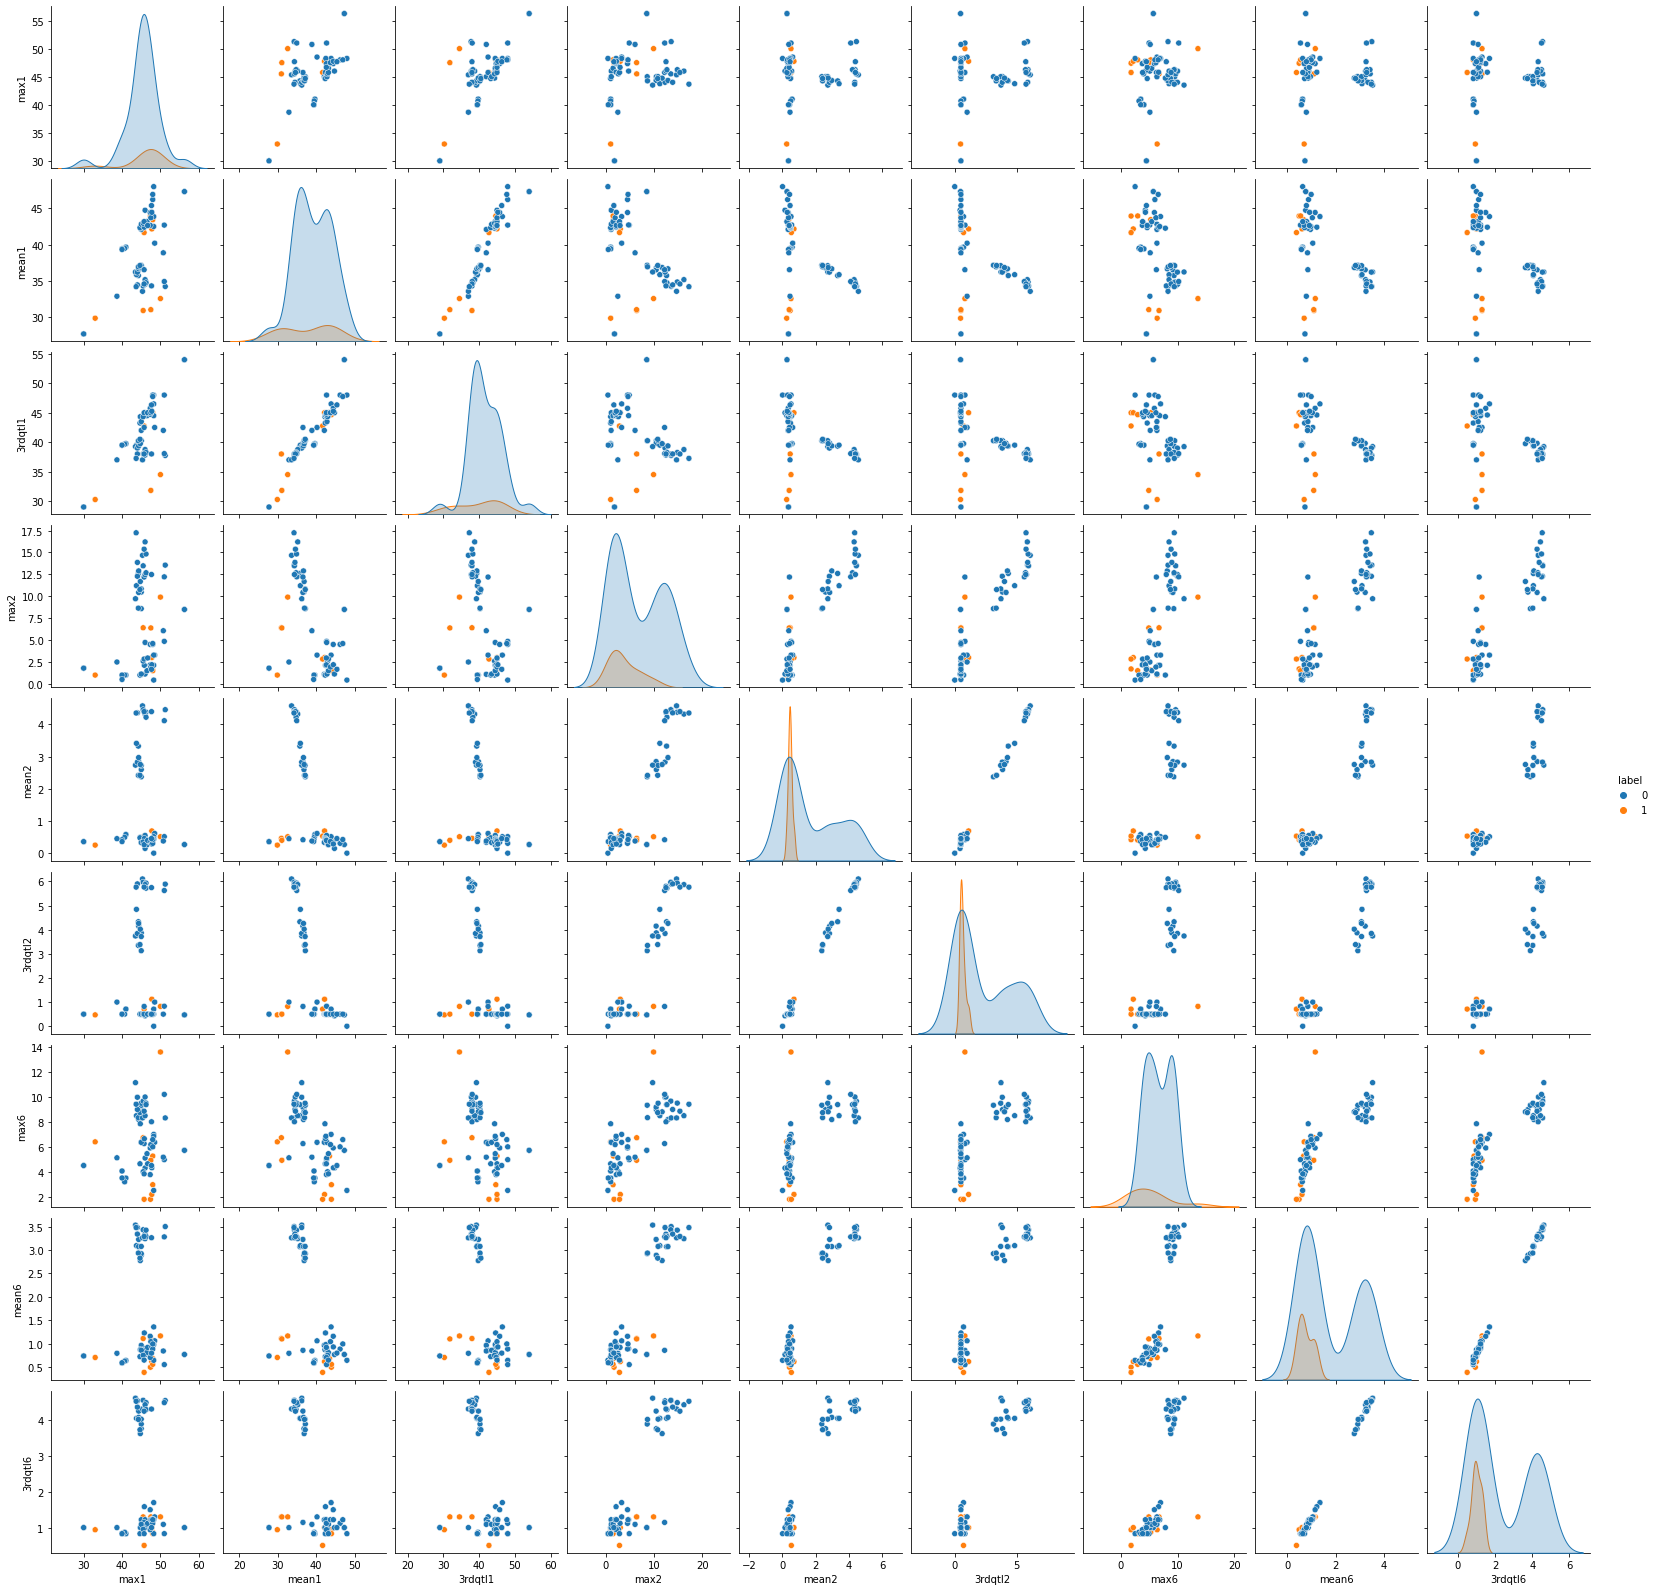

In [13]:
def join_plot(feature, data, nums):
    feature_selection = [f + str(i) for i in nums for f in feature]
    feature_data = data[feature_selection + ['label']]
    sns.pairplot(feature_data, hue='label')
    plt.show()

join_plot( ['max', 'mean', '3rdqtl'],bending_train_df, [1, 2, 6])

Q4_a_Binary Classification Using Logistic Regression

Q4_a_(i)_Break each time series in your training set into two (approximately) equal
length time series.

In [21]:
stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
feature = [stat + str(i) for i in range(1, 13) for stat in stats]
train_df_2fold = read_data(train_data, feature, columns_main, segs=2)
test_df_2fold = read_data(test_data, feature, columns_main, segs=2)

bending_train_2fold = pd.DataFrame(train_df_2fold)
bending_train_2fold.loc[bending_train_2fold['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_train_2fold.loc[bending_train_2fold['label'] != 1, 'label'] = 0
bending_train_2fold

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl11,3rdqtl11,min12,max12,mean12,median12,std12,1stqtl12,3rdqtl12,label
0,36.50,46.50,44.057167,44.500,1.556971,43.2500,45.0000,0.0,1.50,0.381042,...,33.0000,36.2500,0.00,1.50,0.388333,0.000,0.478528,0.0000,0.7100,1
1,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,0.0,3.00,0.673292,...,28.7500,33.7500,0.00,2.18,0.586083,0.470,0.491873,0.0000,0.8700,1
2,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,0.0,2.83,0.623083,...,28.3100,30.5625,0.00,1.50,0.347500,0.430,0.363144,0.0000,0.5000,1
3,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,0.0,1.30,0.250042,...,22.5000,23.7500,0.00,4.06,0.543875,0.500,0.473445,0.4300,0.7100,1
4,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,0.0,1.30,0.378667,...,21.0000,23.5000,0.00,2.96,0.585750,0.500,0.487918,0.4225,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,22.33,46.00,34.966250,35.500,4.733014,32.0000,38.7500,0.0,12.68,4.207958,...,14.0000,18.5000,0.00,9.39,3.430208,3.350,1.647979,2.1700,4.4400,0
65,21.50,45.67,34.737042,35.500,4.276717,32.0000,37.7500,0.0,12.21,4.217333,...,14.5000,18.2500,0.00,10.21,3.225917,3.085,1.665326,2.0500,4.3500,0
66,18.33,45.00,33.886458,34.375,5.143776,30.4575,37.5000,0.0,12.44,4.332208,...,13.6275,18.2500,0.00,8.01,3.274750,2.955,1.670593,2.0500,4.4375,0
67,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,0.0,12.38,4.257750,...,13.9375,18.2500,0.47,8.84,3.409458,3.110,1.707089,2.1700,4.3450,0


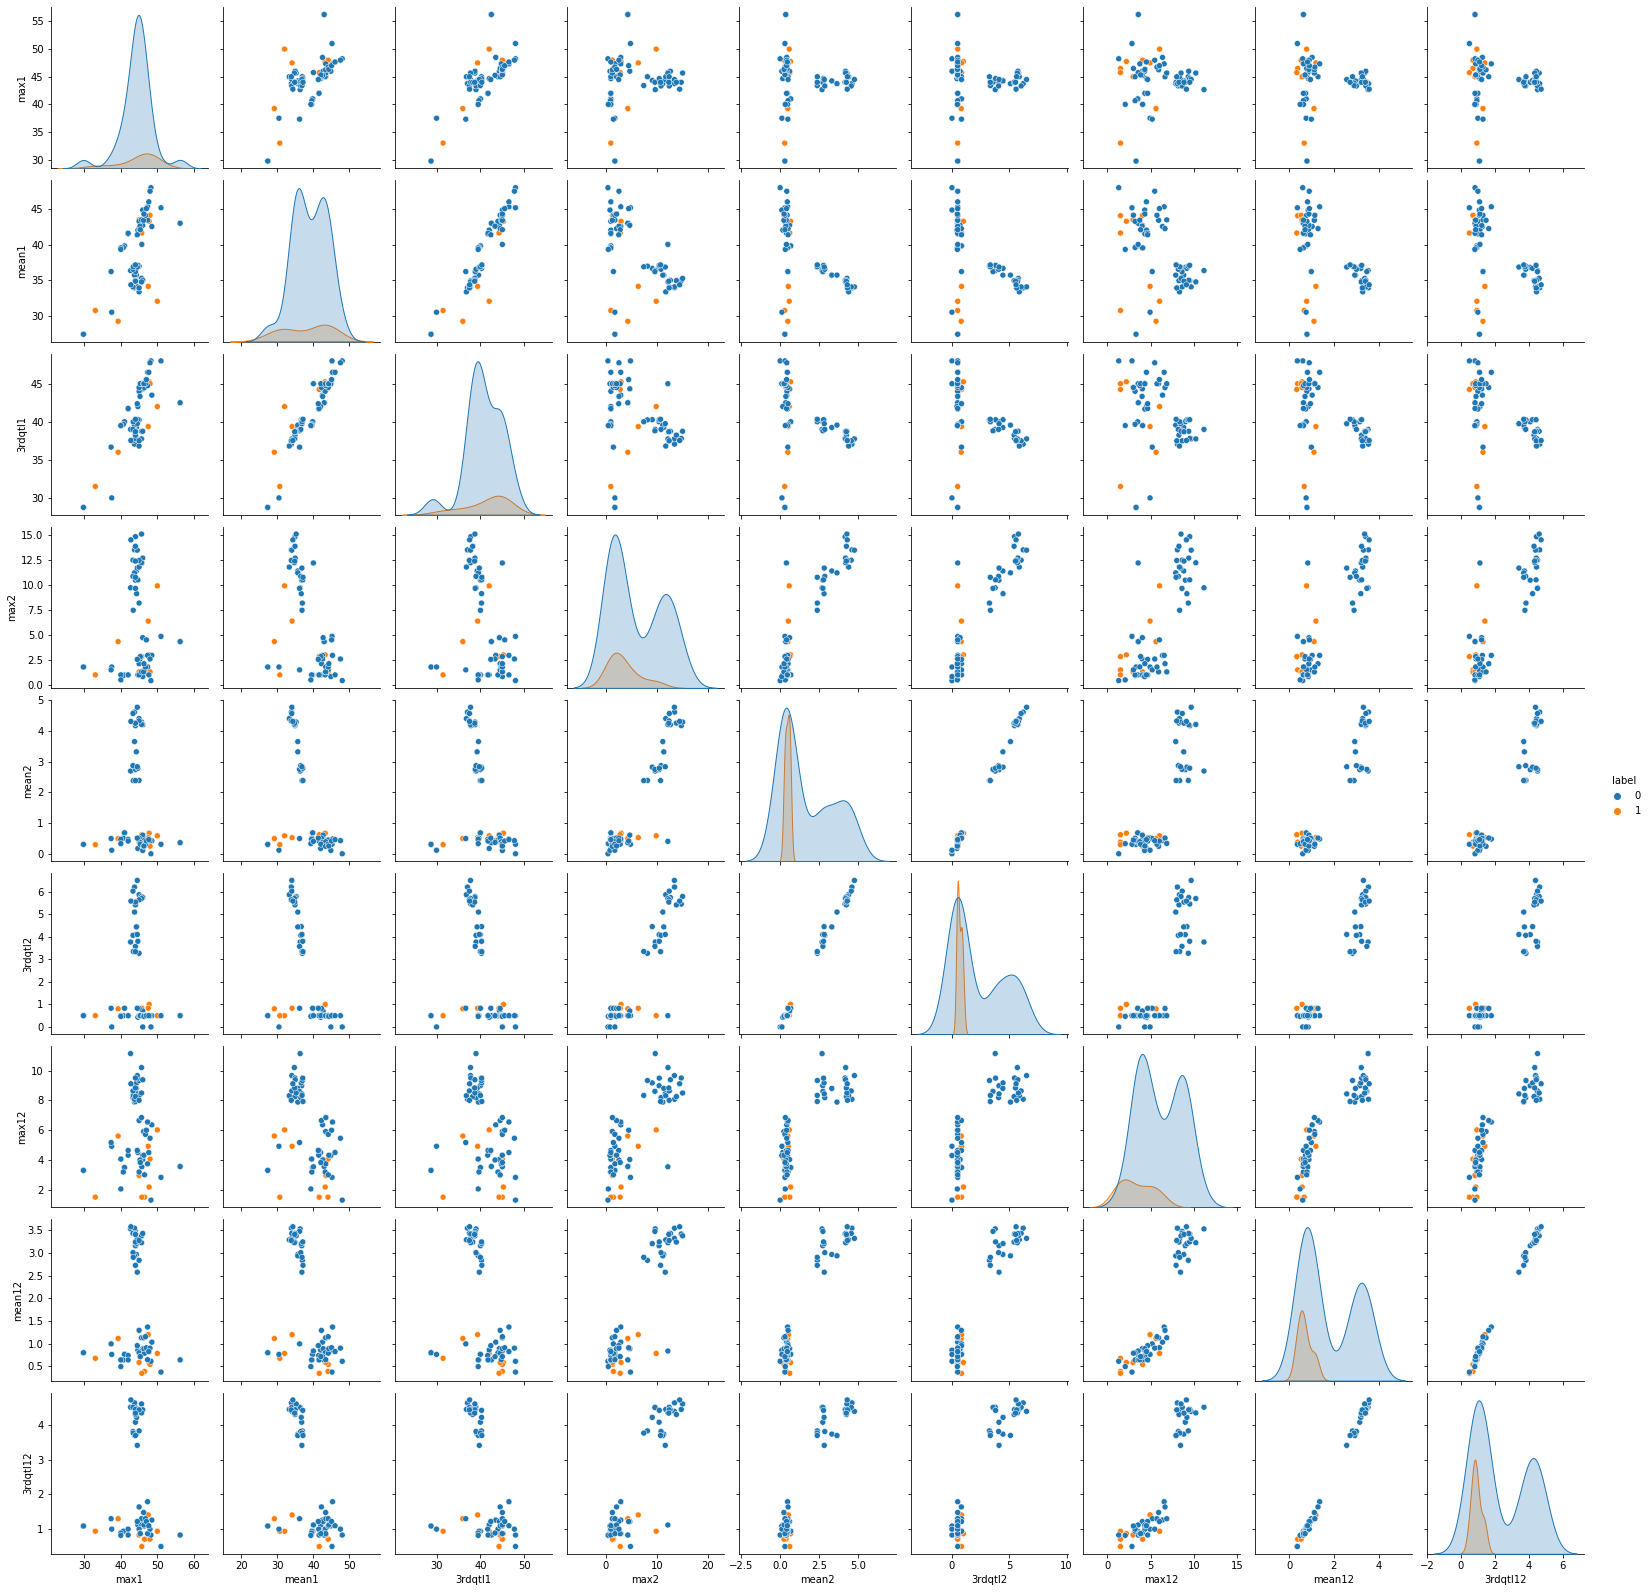

In [24]:
join_plot(['max', 'mean', '3rdqtl'],bending_train_2fold, [1, 2, 12] )

Q4_a_(ii):Break each time series in your training set into l={1,2...20} time series
of approximately equal length and use logistic regression to solve the binary
classification problem, using time-domain features

In [60]:
def logistic_regression(train_data, fold, l_val, penalty_type, oversample_flag):
    orig_col = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
    feature = [stat + str(i) for i in range(1, 6 * l_val + 1) for stat in stats]
    
    train_set = read_data(train_data, feature, orig_col, segs=l_val)
    train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
    train_set.loc[train_set['label'] != "1", 'label'] = "0"
    
    if oversample_flag:
        count_0 = train_set.loc[train_set['label'] == "0"].shape[0]
        count_1 = train_set.loc[train_set['label'] == "1"].shape[0]
        minor_cnt = min(count_0, count_1)
        major_cnt = max(count_0, count_1)
        
        if count_1>count_0:
            minor_class="0"
        else:
            minor_class="1"
                
        minority = train_set.loc[train_set['label'] == minor_class]
        majority = train_set.loc[train_set['label'] != minor_class]
        minority = resample(minority, replace=True, random_state=60,
                         n_samples=max(count_0, count_1))
        train_set = pd.concat([majority, minority])
        print("The data was Oversampled leading the minority_class from {} to {} samples".format(minor_cnt, 
                                                                     major_cnt))
    

    trainX = train_set.iloc[:, :-1] 
    trainY= train_set.iloc[:, -1]
        
    
    if penalty_type == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    cross_validation = StratifiedKFold(n_splits=fold, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty_type, solver=solver, max_iter=100)
    model_final = RFECV(estimator=model, cv=cross_validation, scoring='accuracy')
    model_final.fit(trainX, trainY)
    
    return model, model_final


In [63]:
def loop_Lval(train_files, fold, l_value,penalty='none',flag=False):
    p_val = []
    model_score = []
    
    for l in range(1, l_value + 1):
        model, model_final = logistic_regression(train_files,fold=fold, l_val=l, penalty_type=penalty,oversample_flag=flag)
        p_val.append(model_final.n_features_)
        model_score.append(model_final.grid_scores_)
        print("Pair {}, scores {}".format((l, p_val[-1]), 
                                          round(max(model_final.grid_scores_), 2)))

In [64]:
loop_Lval(train_data,5,20)

Pair (1, 6), scores 1.0
Pair (2, 2), scores 0.97
Pair (3, 10), scores 0.97
Pair (4, 1), scores 0.97
Pair (5, 11), scores 0.97
Pair (6, 5), scores 0.99
Pair (7, 14), scores 0.96
Pair (8, 26), scores 0.96
Pair (9, 11), scores 0.96
Pair (10, 20), scores 0.96
Pair (11, 1), scores 0.97
Pair (12, 6), scores 0.99
Pair (13, 12), scores 1.0
Pair (14, 16), scores 0.99
Pair (15, 16), scores 0.99
Pair (16, 13), scores 0.99
Pair (17, 12), scores 1.0
Pair (18, 4), scores 0.99
Pair (19, 5), scores 0.99
Pair (20, 3), scores 1.0


Q4_a_iii: Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression B_i's as well
as the p-values associated with them

In [86]:
stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in stats]

model, model_final = logistic_regression(train_data, 5, 1, 
                                            penalty_type='none', oversample_flag=False)
feature_sel = [f for i, f in enumerate(feature) if model_final.support_[i]]
feature_sel

['mean1', '3rdqtl1', 'max2', 'min5', 'max5', '1stqtl5']

In [87]:
train_set = read_data(train_data, feature,columns_main , segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0
trainX= train_set.iloc[:, :-1]
trainY= train_set.iloc[:, -1]
trainX_x0 = sm.add_constant(trainX.loc[:, feature_sel].to_numpy(dtype=float))
model_log = sm.Logit(trainY.to_numpy(dtype=float), trainX_x0)

model_logicalReg = model_log.fit(method='bfgs')

print(model_logicalReg.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Tue, 13 Jul 2021   Pseudo R-squ.:                   1.000
Time:                        11:20:35   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

(69,)
[[60  0]
 [ 0  9]]


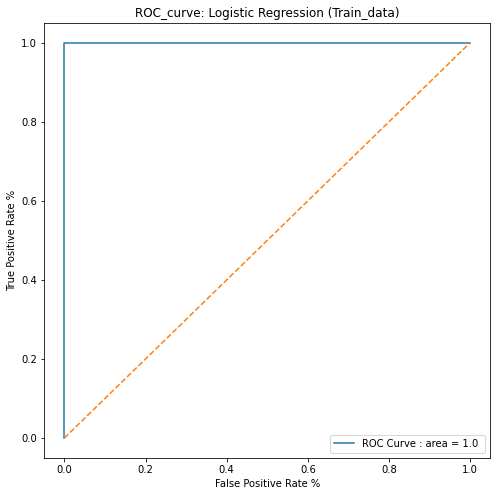

In [90]:
print(trainY.shape)
model.fit(trainX.loc[:, feature_sel], trainY.to_numpy(dtype="int"))
predY = model.predict(trainX.loc[:, feature_sel])
predY_confidence = model.predict_proba(trainX.loc[:, feature_sel])

fpr, tpr, threshold = roc_curve(trainY.to_numpy(dtype="int"), predY_confidence[:, 1], pos_label=1)
cm = confusion_matrix(trainY.to_numpy(dtype=float), predY.round())
print(cm)

fig, axs = plt.subplots(figsize=(8, 8))
model_auc = auc(fpr, tpr)
axs.plot(fpr, tpr, label="ROC Curve : area = {} ".format(model_auc))
axs.plot([0, 1], [0, 1], "--")
axs.set_xlabel("False Positive Rate %")
axs.set_ylabel("True Positive Rate %")
axs.legend()
axs.set_title("ROC_curve: Logistic Regression (Train_data)")
plt.show()

Q4_a_iv: Test the classifier on the test set.

[[15  0]
 [ 0  4]]


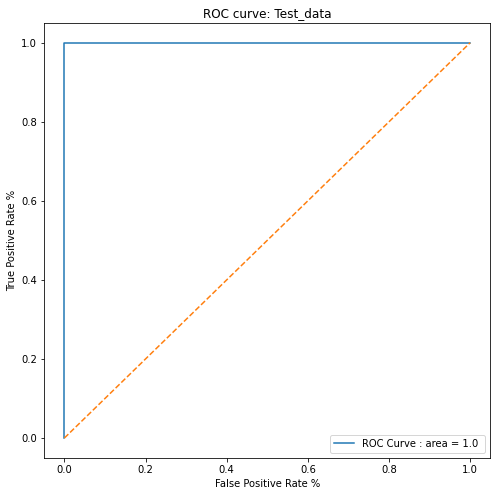

In [91]:
test_set = read_data(test_data, feature,columns_main , segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX = test_set.iloc[:, :-1]
testY = test_set.iloc[:, -1]

predY = model.predict(testX.loc[:, feature_sel])
predY_prob = model.predict_proba(testX.loc[:, feature_sel])

fpr, tpr, threshold = roc_curve(testY.to_numpy(dtype="int"), predY_prob[:, 1], pos_label=1)

cm1 = confusion_matrix(testY.astype(int), predY.astype(int))
print(cm1)

fig, axs = plt.subplots(figsize=(8, 8))
model_auc = auc(fpr, tpr)
axs.plot(fpr, tpr, label="ROC Curve : area = {} ".format(model_auc))
axs.plot([0, 1], [0, 1], "--")
axs.set_xlabel("False Positive Rate %")
axs.set_ylabel("True Positive Rate %")
axs.legend()
axs.set_title("ROC curve: Test_data")
plt.show()

By comparision, test_set Accuracy and cross_validation Accuracy at par with each other, equally good.

Q4_a_v: Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

Yes, the classes seem to be well-separated. Reason: "Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified." is the conlusion of the report.

Q4_a_vi: From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model

Class_0 : 60 samples compared to Class_1: 9 samples. Yes it is imbalanced set.

In [92]:
loop_Lval(train_data,5,20,flag=True)

The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (1, 7), scores 1.0
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (2, 6), scores 0.99
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (3, 6), scores 1.0
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (4, 13), scores 0.99
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (5, 5), scores 1.0
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (6, 10), scores 1.0
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (7, 4), scores 1.0
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (8, 8), scores 0.99
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (9, 8), scores 1.0
The data was Oversampled leading the minority_class from 9 to 60 samples
Pair (10, 4), scores 1.0
The data was Oversampled

In [93]:
stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in stats]

model, model_final = logistic_regression(train_data, 5, 1, 
                                            penalty_type='none', oversample_flag=True)
feature_sel = [f for i, f in enumerate(feature) if model_final.support_[i]]
feature_sel

The data was Oversampled leading the minority_class from 9 to 60 samples


['3rdqtl1', 'median3', 'min5', 'max5', 'mean5', '1stqtl5', 'max6']

The data was Oversampled leading the minority_class from 9 to 60 samples
[[60  0]
 [ 0 60]]


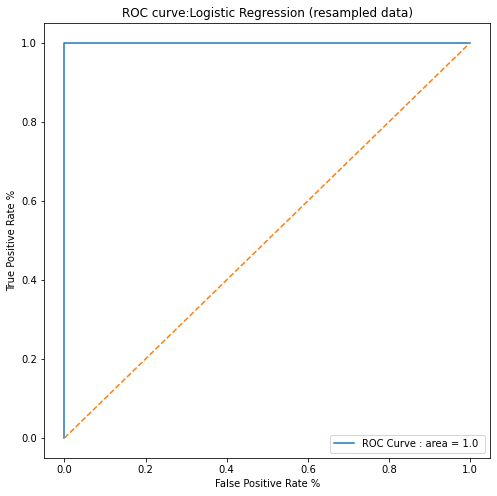

In [97]:
train_set = read_data(train_data, feature,columns_main , segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0

class_0 = train_set.loc[train_set['label'] == 0].shape[0]
class_1 = train_set.loc[train_set['label'] == 1].shape[0]
minor_cnt = min(class_0, class_1)
major_cnt = max(class_0, class_1)
if class_1>class_0:
    minor_class=0
else:
    minor_class=1
minority = train_set.loc[train_set['label'] == minor_class]
majority = train_set.loc[train_set['label'] != minor_class]
minority = resample(minority, replace=True, 
                         n_samples=max(class_0, class_1))
train_set = pd.concat([majority, minority])
print("The data was Oversampled leading the minority_class from {} to {} samples".format(minor_cnt,major_cnt))
trainX = train_set.iloc[:, :-1] 
trainY= train_set.iloc[:, -1]

model.fit(trainX.loc[:, feature_sel], trainY.to_numpy(dtype="int"))
predY = model.predict(trainX.loc[:, feature_sel])
predY_prob = model.predict_proba(trainX.loc[:,feature_sel])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predY_prob[:, 1], pos_label=1)

cm2 = confusion_matrix(trainY.to_numpy(dtype=float), predY.round())
print(cm2)

fig, axs = plt.subplots(figsize=(8, 8))
model_auc = auc(fpr, tpr)
axs.plot(fpr, tpr, label="ROC Curve : area = {} ".format(model_auc))
axs.plot([0, 1], [0, 1], "--")
axs.set_xlabel("False Positive Rate %")
axs.set_ylabel("True Positive Rate %")
axs.legend()
axs.set_title("ROC curve:Logistic Regression (resampled data)")
plt.show()

Q4_b_i: Binary Classification Using L1-penalized logistic regression

In [101]:
def loop_l1(clf, binary_flag,keyphrase):
    for l in range(1, 20 + 1):
        columns_main = ['# Columns: time', 
                        'avg_rss12', 'var_rss12', 
                        'avg_rss13', 'var_rss13', 
                        'avg_rss23', 'var_rss23']
        
        stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
        feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in stats]
        
        train_set = read_data(train_data, feature,columns_main , segs=l)
        test_set = read_data(test_data, feature,columns_main , segs=l)
        
        if binary_flag:
            train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            train_set.loc[train_set['label'] != "1", 'label'] = "0"
            test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            test_set.loc[test_set['label'] != "1", 'label'] = "0"
        
        trainX = train_set.iloc[:, :-1] 
        trainY = train_set.iloc[:, -1]
        testX  = test_set.iloc[:, :-1]
        testY  = test_set.iloc[:, -1]
        
        clf_model = clf(**keyphrase)
        clf_model.fit(trainX, trainY)
        
        train_score = clf_model.score(trainX, trainY)
        test_score = clf_model.score(testX, testY)
        
        print("case of l ~ {} : train_scores = {}, test_score = {}".format(l, 
                                                     round(train_score, 4), 
                                                     round(test_score, 4)))

        
def ROC_curve_plot(clf, Y_true, predY_prob, title):
    fig, axs = plt.subplots(figsize=(8, 8))
    for i, c in enumerate(clf.classes_):
        fpr, tpr, thresholds = roc_curve(Y_true, predY_prob[:, i], pos_label=c)
        model_auc = auc(fpr, tpr)
        axs.plot(fpr, tpr, label="ROC_Curve of class {} : area = {} ".format(c, round(model_auc, 4)))
    axs.plot([0, 1], [0, 1], "--")
    axs.set_xlabel("False Positive Rate")
    axs.set_ylabel("True Positive Rate")
    axs.legend()
    axs.set_title("ROC curves of {}".format(title))
    plt.show()


def optimizer_test(l, clf, keyphrase, binary_flag):
    columns_main = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
    feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in stats]
    
    train_set = read_data(train_data, feature, columns_main, segs=l)
    test_set = read_data(test_data, feature, columns_main, segs=l)
    
    if binary_flag:
        train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        train_set.loc[train_set['label'] != "1", 'label'] = "0"
        test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        test_set.loc[test_set['label'] != "1", 'label'] = "0"
    
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    clf_model = clf(**keyphrase)
    clf_model.fit(trainX, trainY)
    
    predYtrain_prob = clf_model.predict_proba(trainX)
    predY_prob = clf_model.predict_proba(testX)
    
    predY = clf_model.predict(testX)
    cm = confusion_matrix(testY, predY)
    print("Confusion matrix on test set:\n{}".format(cm))
    
    ROC_curve_plot(clf_model, trainY, predYtrain_prob, "Train Set")
    ROC_curve_plot(clf_model, testY, predY_prob, "Test Set")

In [103]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

loop_l1(clf=LogisticRegressionCV, binary_flag=True,keyphrase=kwargs)

case of l ~ 1 : train_scores = 1.0, test_score = 1.0
case of l ~ 2 : train_scores = 1.0, test_score = 1.0
case of l ~ 3 : train_scores = 1.0, test_score = 1.0
case of l ~ 4 : train_scores = 1.0, test_score = 0.9474
case of l ~ 5 : train_scores = 1.0, test_score = 0.9474
case of l ~ 6 : train_scores = 1.0, test_score = 0.9474
case of l ~ 7 : train_scores = 1.0, test_score = 1.0
case of l ~ 8 : train_scores = 1.0, test_score = 0.9474
case of l ~ 9 : train_scores = 1.0, test_score = 0.9474
case of l ~ 10 : train_scores = 1.0, test_score = 0.9474
case of l ~ 11 : train_scores = 1.0, test_score = 0.9474
case of l ~ 12 : train_scores = 1.0, test_score = 1.0
case of l ~ 13 : train_scores = 1.0, test_score = 1.0
case of l ~ 14 : train_scores = 1.0, test_score = 0.9474
case of l ~ 15 : train_scores = 1.0, test_score = 1.0
case of l ~ 16 : train_scores = 1.0, test_score = 1.0
case of l ~ 17 : train_scores = 1.0, test_score = 1.0
case of l ~ 18 : train_scores = 1.0, test_score = 0.9474
case of l 

Confusion matrix on test set:
[[15  0]
 [ 0  4]]


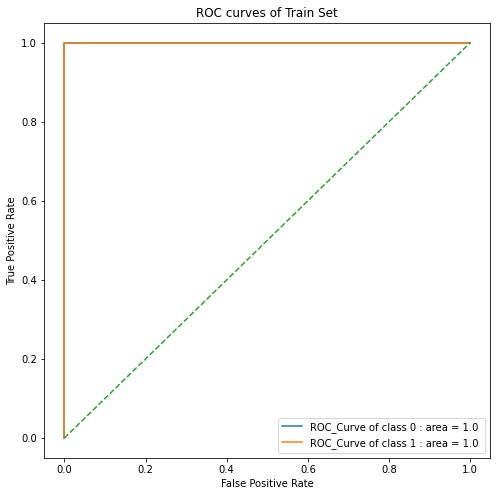

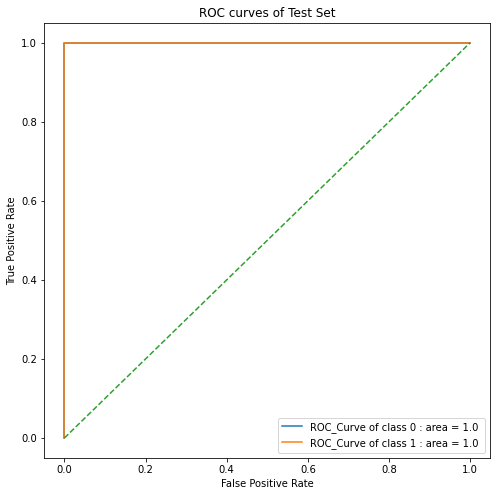

In [104]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

optimizer_test(l=1, clf=LogisticRegression, keyphrase=kwargs, binary_flag=True)

Q4_b_ii: Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

L1-penalized model has a better result on cross-Validation with a score of 1.0 on testdata.

L1-regularization is easy to implement as we dont need to manually select the features after computing p-values.

Q4_c : Multi-class Classification

Q4_c_i: Find the best l in the same way as you found it in 4(b)i to build an L1-
penalized multinomial regression model to classify all activities in your training
set.11 Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem
if possible

In [105]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class' : 'multinomial',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'saga'
}

loop_l1(clf=LogisticRegressionCV, binary_flag=False,keyphrase=kwargs)

case of l ~ 1 : train_scores = 0.9565, test_score = 0.8947
case of l ~ 2 : train_scores = 1.0, test_score = 0.9474
case of l ~ 3 : train_scores = 1.0, test_score = 0.8421
case of l ~ 4 : train_scores = 1.0, test_score = 0.8947
case of l ~ 5 : train_scores = 1.0, test_score = 0.8421
case of l ~ 6 : train_scores = 1.0, test_score = 0.7895
case of l ~ 7 : train_scores = 1.0, test_score = 0.7368
case of l ~ 8 : train_scores = 1.0, test_score = 0.7895
case of l ~ 9 : train_scores = 1.0, test_score = 0.7895
case of l ~ 10 : train_scores = 1.0, test_score = 0.8421
case of l ~ 11 : train_scores = 1.0, test_score = 0.8421
case of l ~ 12 : train_scores = 1.0, test_score = 0.7895
case of l ~ 13 : train_scores = 1.0, test_score = 0.7895
case of l ~ 14 : train_scores = 1.0, test_score = 0.8421
case of l ~ 15 : train_scores = 1.0, test_score = 0.7895
case of l ~ 16 : train_scores = 1.0, test_score = 0.7895
case of l ~ 17 : train_scores = 1.0, test_score = 0.7895
case of l ~ 18 : train_scores = 1.0, 

Selection : with best test score of 0.9474, l=2 is our best choice.

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


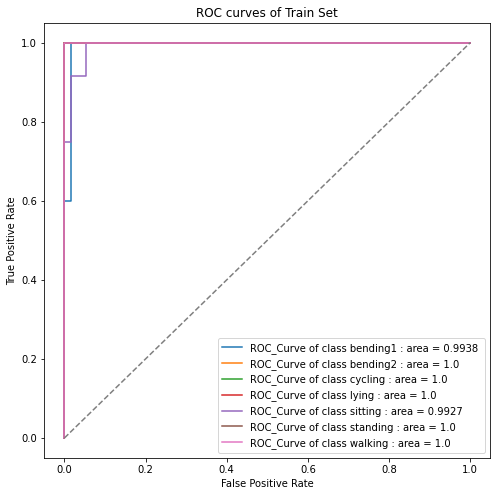

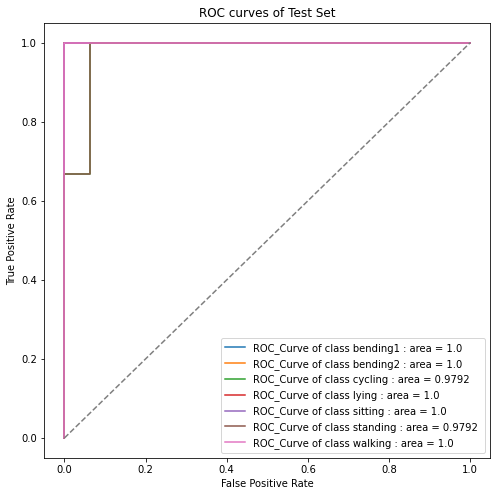

In [106]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial', 
    'solver' : 'saga'
}

optimizer_test(l=2, clf=LogisticRegression, keyphrase=kwargs, binary_flag=False)

Q4_c_ii: Repeat 4(c)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial
pdfs and compare the results.

In [110]:
loop_l1(clf=GaussianNB, binary_flag=False,keyphrase={})

case of l ~ 1 : train_scores = 1.0, test_score = 0.8947
case of l ~ 2 : train_scores = 1.0, test_score = 0.6316
case of l ~ 3 : train_scores = 0.9855, test_score = 0.7368
case of l ~ 4 : train_scores = 1.0, test_score = 0.7895
case of l ~ 5 : train_scores = 0.9855, test_score = 0.7895
case of l ~ 6 : train_scores = 0.971, test_score = 0.6316
case of l ~ 7 : train_scores = 1.0, test_score = 0.7368
case of l ~ 8 : train_scores = 0.9855, test_score = 0.7368
case of l ~ 9 : train_scores = 1.0, test_score = 0.6842
case of l ~ 10 : train_scores = 1.0, test_score = 0.7895
case of l ~ 11 : train_scores = 0.9855, test_score = 0.6842
case of l ~ 12 : train_scores = 1.0, test_score = 0.6316
case of l ~ 13 : train_scores = 1.0, test_score = 0.7368
case of l ~ 14 : train_scores = 1.0, test_score = 0.5789
case of l ~ 15 : train_scores = 1.0, test_score = 0.5789
case of l ~ 16 : train_scores = 1.0, test_score = 0.5263
case of l ~ 17 : train_scores = 1.0, test_score = 0.5263
case of l ~ 18 : train_sco

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


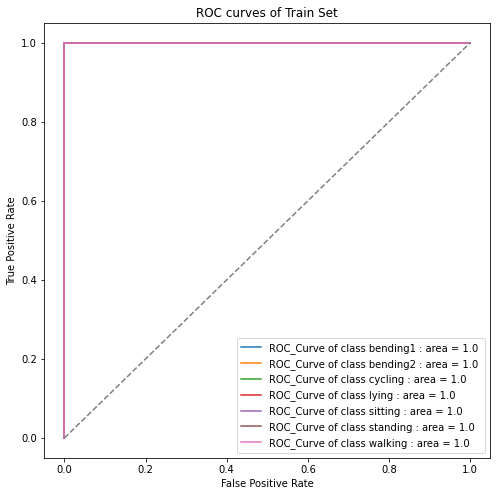

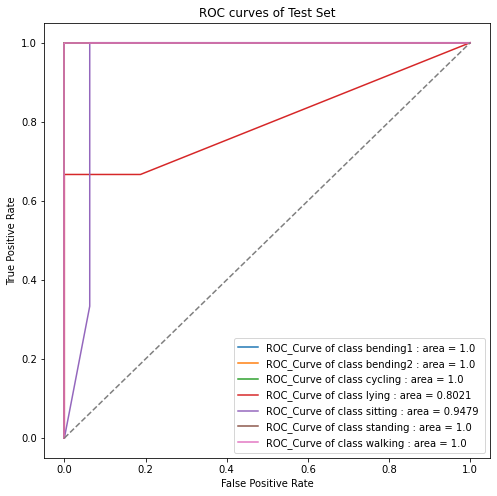

In [111]:
optimizer_test(l=1, clf=GaussianNB, keyphrase={}, binary_flag=False)

In [120]:
def loop_Lval_Naive(traindata,testdata, fold, l_value,binary_flag):
    p_val = []
    model_score = []
    
    columns_main = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    stats = ['min','max','mean','median','std','1stqtl', '3rdqtl']
    feature = [stat + str(i) for i in range(1, 6 * l_value + 1) for stat in stats]
    
    train_set = read_data(traindata, feature, columns_main, segs=l_value)
    test_set = read_data(testdata, feature, columns_main, segs=l_value)
    
    if binary_flag:
        train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        train_set.loc[train_set['label'] != "1", 'label'] = "0"
        test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        test_set.loc[test_set['label'] != "1", 'label'] = "0"
    
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    
    for l in range(1, l_value + 1): 
        
        cross_validation = StratifiedKFold(n_splits=fold, shuffle=True, random_state=69)
        model = GaussianNB()
        model_final = RFECV(estimator=model, cv=cross_validation, scoring='accuracy')
        model_final.fit(trainX, trainY)
        p_val.append(model_final.n_features_)
        model_score.append(model_final.grid_scores_)
        print("Pair {}, scores {}".format((l, p_val[-1]), 
                                          round(max(model_final.grid_scores_), 4)))

loop_Lval_Naive(traindata=train_data,testdata=test_data,fold=5,l_value=20,binary_flag=False)

ValueError: when `importance_getter=='auto'`, the underlying estimator GaussianNB should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

Q4_c_iv: Which method is better for multi-class classification in this problem

Logistic regression has better ROC curves for all classes, Hence relatively better model for classification.